In [68]:
import copy
import sys
import torchxrayvision as xrv
import skimage, torch, torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
import cv2

sys.path.insert(0, "..")

from my_models import *
from methods import *

In [2]:
SAVETO_DIR = "images"

In [3]:
def plot_pts(xs, cmap=None):
    assert isinstance(xs, list)
    num_xs = len(xs)
    plt.clf()
    if num_xs == 1:
        fig = plt.imshow(xs[0].numpy().transpose(1,2,0), cmap=cmap)
    else:
        fig, ax = plt.subplots(1,num_xs)
        for i in range(num_xs):
            ax[i].imshow(xs[i].numpy().transpose(1,2,0), cmap=cmap)
    return fig

In [104]:
class SegModel(nn.Module):
    def __init__(self, base_model):
        super(SegModel, self).__init__()
        self.base_model = copy.deepcopy(base_model)
        self.image_size = (1,224,224)
        self.patch_size = 28
        self.grid_h_len = self.image_size[1] // self.patch_size
        self.grid_w_len = self.image_size[2] // self.patch_size
        self.p = self.grid_h_len * self.grid_w_len
        
    def alpha_shape(self, x):
        return torch.Size([x.size(0), self.p])
    
    def binner_product(self, x, alpha):
        N, p = alpha.shape
        alpha = alpha.view(N,1,self.grid_h_len,self.grid_w_len).float()
        x_noised = F.interpolate(alpha, scale_factor=self.patch_size * 1.0) * x
        return x_noised    
    
    def forward(self, x, alpha=None):
        alpha = torch.ones(x.size(0), self.p).to(x.device) if alpha is None else alpha
        x_masked = self.binner_product(x, alpha)
        y = self.base_model(x_masked)
        return y

In [105]:
model = xrv.models.DenseNet(weights="densenet121-res224-nih").eval()
gmodel = SegModel(model).eval()

# smodel = MuSImageNet(model, patch_size=28, q=64, lambd=1.0, image_shape=(1,224,224))
# smodel.cpu().eval()
# smodel.use_voting = False

In [106]:
IMAGES_DIR = "/home/antonxue/foo/data/nih-hello"
image_files = os.listdir(IMAGES_DIR)
image_files = sorted(image_files)
image_files = [os.path.join(IMAGES_DIR, f) for f in image_files]

In [107]:
image_files[245]

'/home/antonxue/foo/data/nih-hello/00010264_005.png'

In [108]:
# img = skimage.io.imread("/home/antonxue/foo/data/nih-hello/00010216_001.png")
raw_img = skimage.io.imread("images/00010216_001.png")
img = xrv.datasets.normalize(raw_img, 255) # convert 8-bit image to [-1024, 1024] range
img = torch.from_numpy(img).view(1,224,224)

In [109]:
method = GradShapExplainer(0.25, num_trains=96)
torch.cuda.empty_cache()

In [116]:
torch.manual_seed(1234)
np.random.seed(1234)
alpha, order = method.find_explanation(gmodel, img, get_order=True)
beta = alpha.clone()
beta[1] = 1
torch.cuda.empty_cache()

In [117]:
next(gmodel.parameters()).device

device(type='cuda', index=0)

In [118]:
with torch.no_grad():
    y = gmodel(img[None,...].cuda())
    ya = gmodel(img[None,...].cuda(), alpha=alpha[None,...].cuda())
    yb = gmodel(img[None,...].cuda(), alpha=beta[None,...].cuda())

In [119]:
(ya - yb).abs().max()

tensor(0.2049, device='cuda:0')

In [120]:
(ya - yb).abs().argmax(), y[0,8], ya[0,8], yb[0,8], model.pathologies[8]

(tensor(8, device='cuda:0'),
 tensor(0.2550, device='cuda:0'),
 tensor(0.2956, device='cuda:0'),
 tensor(0.5005, device='cuda:0'),
 'Pneumonia')

In [123]:
img_alpha = gmodel.binner_product(raw_img[None,...], alpha[None,...])[0]
img_beta = gmodel.binner_product(raw_img[None,...], beta[None,...])[0]

<Figure size 640x480 with 0 Axes>

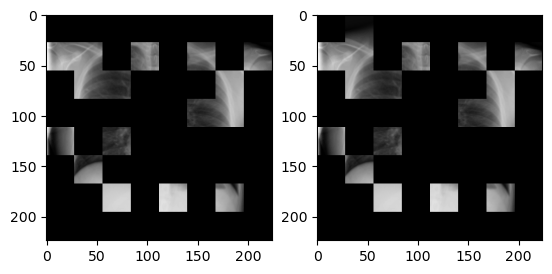

In [124]:
plot_pts([img_alpha, img_beta], cmap="gray");

In [125]:
ialpha = img_alpha.view(224,224)
ibeta = img_beta.view(224,224)

icolor = cv2.cvtColor(raw_img, cv2.COLOR_GRAY2BGR)
ialpha_color = cv2.cvtColor(ialpha.numpy(), cv2.COLOR_GRAY2BGR)
ibeta_color = cv2.cvtColor(ibeta.numpy(), cv2.COLOR_GRAY2BGR)

icolor = torch.tensor(icolor.transpose(2,0,1)) / 256
ialpha_color = torch.tensor(ialpha_color.transpose(2,0,1)) / 256
ibeta_color = torch.tensor(ibeta_color.transpose(2,0,1)) / 256

<Figure size 640x480 with 0 Axes>

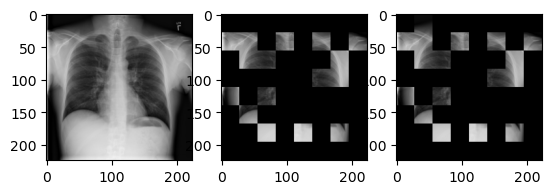

In [126]:
plot_pts([icolor, ialpha_color, ibeta_color]);

In [127]:
plt.imsave(os.path.join(SAVETO_DIR, "00010216_001_color.png"), icolor.numpy().transpose(1,2,0))
plt.imsave(os.path.join(SAVETO_DIR, "00010216_001_ab.png"), ialpha_color.numpy().transpose(1,2,0))
plt.imsave(os.path.join(SAVETO_DIR, "00010216_001_bad.png"), ibeta_color.numpy().transpose(1,2,0))

In [63]:
ialpha = img_alpha.view(224,224)
ibeta = img_beta.view(224,224)

I8_alpha = (((ialpha - ialpha.min()) / (ialpha.max() - ialpha.min())) * 255.9).numpy().astype(np.uint8)
I8_beta = (((ibeta - ibeta.min()) / (ibeta.max() - ibeta.min())) * 255.9).numpy().astype(np.uint8)

pil_img_alpha = Image.fromarray(I8_alpha)
pil_img_beta = Image.fromarray(I8_beta)

pil_img_alpha.save(os.path.join(SAVETO_DIR, "00010216_001_ab.png"))
pil_img_beta.save(os.path.join(SAVETO_DIR, "00010216_001_bad.png"))

# plt.imsave(os.path.join(SAVETO_DIR, "00010216_001_ab.png"), I8_alpha.transpose(1,2,0), cmap=cm.gray)


In [ ]:
best_gap = 0.0
best_i = 0

for i in range(0,1000):
    img = skimage.io.imread(image_files[i])
    img = img[None,...]
    img = xrv.datasets.normalize(img, 255) # convert 8-bit image to [-1024, 1024] range
    
    if not (img.size == 224 * 224):
        print(f"i {i}, mishaped of size {img.size}")
        continue
    
    
    img = torch.from_numpy(img).view(1,224,224).cuda()
    torch.manual_seed(1234)
    np.random.seed(1234)
    alpha, order = method.find_explanation(gmodel, img, get_order=True)
    torch.cuda.empty_cache()
    beta = alpha.clone()
    beta[0] = 1
    
    gmodel.cuda()
    
    ya = gmodel(img[None,...], alpha=alpha[None,...])
    yb = gmodel(img[None,...], alpha=beta[None,...])
    
    gap = (ya - yb).abs().max()
    
    if gap > best_gap:
        best_gap = gap
        best_i = i
    print(f"i {i}, gap {gap:.4f} (best: {best_i}, {best_gap:.4f}, {image_files[best_i]})")